In [37]:
!pip3 install -q requests_cache
!pip3 install -q torch
!pip3 install -q transformers

In [38]:
# import standard libraries
import random
import os
import io
import zipfile
import requests_cache as rqc
import numpy as np
import pandas as pd
import torch as pt
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
import transformers as tsf

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [39]:
# print environment information
print("ENVIRONMENT INFORMATION")
print("Using numpy version %s" % np.__version__)
print("Using pandas version %s" % pd.__version__)
print("Using torch version %s" % pt.__version__)
print("Using transformers version %s" % tsf.__version__)

ENVIRONMENT INFORMATION
Using numpy version 1.22.4
Using pandas version 1.5.3
Using torch version 2.0.0+cu118
Using transformers version 4.29.2


In [40]:
# determine available device
device = pt.device("cpu")
if pt.cuda.is_available() :
  device = pt.device("cuda")
  print("Using GPU acceleration")
  ! nvidia-smi
else:
  print("NOT using GPU acceleration")

Using GPU acceleration
Thu May 18 12:38:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |   5209MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [41]:
# global configuration
LLM_MODEL_GENERATOR = "gpt2"
KEYWORDS_TOKENIZATION_SPACE_LENGTH = 32
TITLE_TOKENIZATION_SPACE_LENGTH = 64
BATCH_SIZE = 16
SPECIAL_TOKENS  = { 
      "pad_token": "<|pad|>",
      'additional_special_tokens': ['<keywords>', '<title>']
    }
TRAIN_EPOCHS = 10

In [42]:
# global initialization - reproducibility
random.seed(0)
np.random.seed(0)
pt.manual_seed(0)

# initialize tqdm for pandas usage
tqdm.pandas()

# disable unimportant warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [43]:
""" Reads the data from a remote zip file """
def get_data_from_remote_zip_file(file_url, file_name, index_col = None):

  response = rqc.CachedSession().get(file_url)
  binary_data = io.BytesIO(response.content)

  raw_data = None

  with zipfile.ZipFile(binary_data) as z:
    with z.open(file_name) as f:
      raw_data = pd.read_csv(f, index_col = index_col)
      
  return raw_data

In [44]:
# create the tokenizer and the model
text_generation_tokenizer = tsf.GPT2Tokenizer.from_pretrained(
    LLM_MODEL_GENERATOR
  )
text_generation_tokenizer.add_special_tokens(SPECIAL_TOKENS)

text_generation_model = tsf.GPT2LMHeadModel.from_pretrained(
    LLM_MODEL_GENERATOR
  )
text_generation_model.resize_token_embeddings(len(text_generation_tokenizer))

text_generation_model = text_generation_model.to(device)

In [45]:
# URL and FILE NAME for paraphrased titles
PARAPHRASED_TITLES_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Content-Enhancement/raw/main/data/processed/paraphrased_titles.zip"
PARAPHRASED_TITLES_FILE_NAME = "paraphrased_titles.csv"

# obtain the paraphrased titles dataframe
paraphrased_titles_data_frame = get_data_from_remote_zip_file(PARAPHRASED_TITLES_URL, PARAPHRASED_TITLES_FILE_NAME, index_col = 0)

In [46]:
# URL and FILE NAME for summarized text keywords
SUMMARIZED_TEXTS_KEYWORDS_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Content-Enhancement/raw/main/data/processed/summarized_texts_keywords.zip"
SUMMARIZED_TEXTS_KEYWORDS_NAME = "summarized_texts_keywords.csv"

# obtain thesummarized text keywords dataframe
summarized_texts_keywords_data_frame = get_data_from_remote_zip_file(SUMMARIZED_TEXTS_KEYWORDS_URL, SUMMARIZED_TEXTS_KEYWORDS_NAME, index_col = 0)

In [47]:
# create raw data
raw_data = summarized_texts_keywords_data_frame.merge(paraphrased_titles_data_frame, on = "original_index", how = "inner")

In [48]:
""" Tokenize data for fine tunning"""
def tokenize_data_for_fine_tunning (
    tokenizer, 
    keywords, 
    title,
    keywords_tokenization_space = KEYWORDS_TOKENIZATION_SPACE_LENGTH,
    title_tokenization_space = TITLE_TOKENIZATION_SPACE_LENGTH
  ) :

    # determine max length for tokenization
    tokenization_max_length = keywords_tokenization_space + title_tokenization_space

    # extract relevant token ids
    keywords_token_id = tokenizer.additional_special_tokens_ids[0]
    title_token_id = tokenizer.additional_special_tokens_ids[1]
    pad_token_id = tokenizer.pad_token_id
    eos_token_id = tokenizer.eos_token_id
    ignore_token_id = -100

    # tokenize keywords up to half of the max allocated length
    tokenized_keywords =  [keywords_token_id] + tokenizer.encode(keywords, max_length = keywords_tokenization_space - 1, truncation = True)

    # tokenize fake news up to half of the max allocated length
    tokenized_titles =  [title_token_id] + tokenizer.encode(title , max_length = title_tokenization_space - 2, truncation = True) + [eos_token_id]

    # create the core sequence for training with extra padding
    core_sequence = tokenized_keywords + tokenized_titles 
    extra_padding = [pad_token_id] * (tokenization_max_length - len(core_sequence)) 
    tokens_data = core_sequence + extra_padding

    # create token types data
    token_types_data = [keywords_token_id] * len(tokenized_keywords) + [title_token_id] * (tokenization_max_length - len(tokenized_keywords)) 

    # create labels data, ignoring keywords and padding
    labels_data = [ignore_token_id] * len(tokenized_keywords) + tokenized_titles + [ignore_token_id]*len(extra_padding)

    tokenization_data = {
        "tokens_data": tokens_data,
        "token_types_data": token_types_data,
        "labels_data": labels_data
    }

    return tokenization_data

In [49]:
# define convenience function for text tokenization
standard_tokenize_data_for_fine_tunning = lambda keywords, title : \
  tokenize_data_for_fine_tunning(
      text_generation_tokenizer, 
      keywords, 
      title, 
      KEYWORDS_TOKENIZATION_SPACE_LENGTH, 
      TITLE_TOKENIZATION_SPACE_LENGTH
    )

In [50]:
""" Extracts tokenized information from an existing item """
def standard_token_text_for_fine_tunning_from_dataframe(item) :
  tokens = standard_tokenize_data_for_fine_tunning(item["keywords"], item["paraphrased_title"])

  return tokens

tokenized_data_for_fine_tunning = raw_data.progress_apply(standard_token_text_for_fine_tunning_from_dataframe, axis = 1)

  0%|          | 0/6594 [00:00<?, ?it/s]

In [51]:
"""Defining a customized dataset for storing the tokenized data"""
class FineTuningDataset(Dataset) :

  def __init__(self, tokenized_data, device = "cpu") :
    self.tokenized_data = tokenized_data

  def __len__(self) :
    return self.tokenized_data.shape[0]

  def __getitem__(self, i) :
    tokenized_data = self.tokenized_data[i]
    item_information = {
        "tokens_data": pt.tensor(tokenized_data["tokens_data"]).to(device),
        "token_types_data": pt.tensor(tokenized_data["token_types_data"]).to(device),
        "labels_data": pt.tensor(tokenized_data["labels_data"]).to(device),
    }

    return item_information

In [52]:
# create the necessary datasets
fine_tuning_dataset = FineTuningDataset(tokenized_data_for_fine_tunning, device = device)

In [53]:
# instantiate the optimizer 
optimizer = pt.optim.RMSprop (
  text_generation_model.parameters(),
  lr = 1e-5,
  eps = 1e-6
)

In [54]:
"""Creates the data loader from a source data set"""
def get_data_loader(dataset, shuffle = False, batch_size = BATCH_SIZE) :
  # instantiate the dataloader
  data_loader = DataLoader(
      dataset,
      shuffle = shuffle,
      batch_size = batch_size
  )

  return data_loader

In [55]:
"""Create the fine tuning training and evaluation data loaders"""
def get_fine_tuning_data_loaders(dataset, batch_size = BATCH_SIZE, split_ratio = (0.75, 0.25)) :
  # split the dataset
  train_dataset, evaluation_dataset = random_split(dataset, split_ratio)

  # create the necessary data loaders
  train_data_loader = get_data_loader(train_dataset, shuffle = True)
  evaluation_data_loader = get_data_loader(evaluation_dataset)

  return train_data_loader, evaluation_data_loader

In [56]:
""" Performs a training step on the model using a new training batch """
def perform_training_step(model, batch, optimizer) :
  # reset text generation model gradients
  text_generation_model.zero_grad()

  # extract input data from batch
  batch_inputs_ids = batch["tokens_data"]
  batch_labels = batch["labels_data"]
  batch_token_type_ids = batch["token_types_data"]

  # collect generated output data, including loss
  outputs = text_generation_model(  
    batch_inputs_ids,
    labels = batch_labels,
    token_type_ids = batch_token_type_ids
  )
  batch_loss = outputs[0]

  # update model and finish training step
  batch_loss.backward()
  optimizer.step()

  return batch_loss

In [57]:
""" Performs a validation step on the model using a new validation batch """
def perform_validation_step(model, batch) :
  # no gradients update needed
  with pt.no_grad() :
    # extract input data from batch
    batch_inputs_ids = batch["tokens_data"]
    batch_labels = batch["labels_data"]
    batch_token_type_ids = batch["token_types_data"]

    # collect generated output data, including loss
    outputs = text_generation_model(  
      batch_inputs_ids,
      labels = batch_labels,
      token_type_ids = batch_token_type_ids 
    )
    batch_loss = outputs[0]

    return batch_loss

In [58]:
epochs_train_losses = []
epochs_validation_losses = []

for epoch_i in range(0, TRAIN_EPOCHS):

  print ("TRAINING EPOCH %s" % str(epoch_i + 1))

  # get the data loaders for training and evaluation
  train_data_loader, evaluation_data_loader = get_fine_tuning_data_loaders(fine_tuning_dataset)

  total_train_loss = 0
  train_steps = len(train_data_loader)
  total_validation_loss = 0
  validation_steps = len(evaluation_data_loader)

  # perform model training
  text_generation_model.train()
  for batch in tqdm(train_data_loader, "[Training]"):
    training_batch_loss = perform_training_step(text_generation_model, batch, optimizer)
    total_train_loss += training_batch_loss.item()

  # collect and display epoch train loss
  epochs_average_train_loss = total_train_loss / train_steps
  epochs_train_losses = np.append(epochs_train_losses, epochs_average_train_loss)
  print ("\tAverage train loss: %.2f" % epochs_average_train_loss)

  # perform model evaluation
  text_generation_model.eval()
  for batch in tqdm(evaluation_data_loader, "[Validation]"):
    evaluation_batch_loss= perform_validation_step(text_generation_model, batch)
    total_validation_loss += evaluation_batch_loss.item()

  # collect and display epoch validation loss
  epochs_average_validation_loss = total_validation_loss / validation_steps
  epochs_validation_losses = np.append(epochs_validation_losses, epochs_average_validation_loss)
  print ("\tAverage validation loss: %.2f" % epochs_average_validation_loss)
    

TRAINING EPOCH 1


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 4.53


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 3.24
TRAINING EPOCH 2


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 3.15


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 2.80
TRAINING EPOCH 3


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.87


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 2.61
TRAINING EPOCH 4


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.67


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 2.43
TRAINING EPOCH 5


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.48


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 2.38
TRAINING EPOCH 6


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.35


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 2.15
TRAINING EPOCH 7


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.23


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 2.05
TRAINING EPOCH 8


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.13


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 1.91
TRAINING EPOCH 9


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 2.02


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 1.79
TRAINING EPOCH 10


[Training]:   0%|          | 0/310 [00:00<?, ?it/s]

	Average train loss: 1.92


[Validation]:   0%|          | 0/103 [00:00<?, ?it/s]

	Average validation loss: 1.68


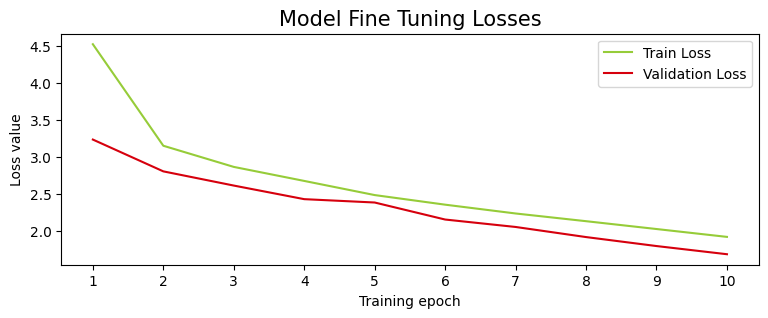

In [84]:
# display fine tuning performance on each epoch
training_plot_data = pd.DataFrame({
    "epoch": range(1, TRAIN_EPOCHS + 1),
    "epochs_train_losses" : epochs_train_losses,
})
validation_plot_data = pd.DataFrame({
    "epoch": range(1, TRAIN_EPOCHS + 1),
    "epochs_validation_losses" : epochs_validation_losses,
})

fig, ax = plt.subplots(figsize=(9,3))

train_loss_line_plot = sns.lineplot(
    ax = ax,
    data = training_plot_data,
    x = "epoch", 
    y = "epochs_train_losses",
    label = "Train Loss",
    color ="#96CC39"
  )

validation_loss_line_plot = sns.lineplot(
    ax = ax,
    data = validation_plot_data,
    x = "epoch", 
    y = "epochs_validation_losses",
    label = "Validation Loss",
    color ="#D6000D"
  )

ax.set(
    xlabel ='Training epoch', 
    ylabel='Loss value'
  )
ax.grid(False)
ax.set_facecolor('white')

plt.xticks(np.arange(1, TRAIN_EPOCHS + 1, 1))

plt.title("Model Fine Tuning Losses", fontsize = 15)

plt.show()

In [85]:
# save the tokenizer and model for further usage
_ = text_generation_tokenizer.save_pretrained("./title_generation_tokenizer")
_ = text_generation_model.save_pretrained("./title_generation_model")